<a href="https://colab.research.google.com/github/jcuesta123/TFM-RL/blob/main/airplane_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTS
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#General parametes
m_a = 1000 # kg
g = 9.81   # m/s2
l_a = 4 # m airplane length
S_w = 4 # m2 wing surface
S_t = S_w/4 # m2 tail wing surface
l_w = 0.5 # m wing_length
#abajo    l_t = l_w*5 # OJO mejor 5
I_a = (1/12) * m_a * (l_a)**2
ro = 1 # kg/m3  air density
pi = math.pi

#State variables
x = 0       # m
z = 100     # m
v = 100     # m/s
gamma = 0   # rad
theta = 0   # rad
v_theta = 0 # rad/s
T = 1500 # N  thrust
EC = 0 # elevator control

#Calculation values
# abajo  deltaT = 0.1 # s

In [ ]:
state = np.array([x, z, v, gamma, theta, v_theta, T, EC])

# gamma = angle between axis x and v_airplane
# theta = angle between axis x and x_airplane
# alpha = theta - gamma (attack angle, how wind impacts on wings)
# T = thrust in N

In [ ]:
#LIFT function
# v_tipic = 100 m/s,  5º or 0.087 rad -> 10 kN

C_L_alpha = 5.73 # coeficcient increase in C_L per radian, = 1CL per 10º
max_C_L_angle = 0.26 #rad, about 15º
C_L_alpha_zero = 0 #

def L(v,alpha, EC):

  # OJO al entorno

  lift_w = 0.5 * ro * v**2 * S_w * (0.25 + 2.87 * alpha)
  lift_t = 0.5 * ro * v**2 * S_t * (0.00 + 5.73 * (alpha + EC))
  lift = lift_w + lift_t

  return lift, lift_w, lift_t

In [ ]:
def D(v,alpha, EC):

  C_D_w = 0.05 + 0.089 * (0.25 + 2.87 * alpha) **2
  C_D_t = 0.05 + 0.089 * (0.00 + 5.73 * (alpha + EC)) **2

  drag = 0.5 * ro * v**2 * (S_w * C_D_w + S_t * C_D_t)


  return drag

In [ ]:
#MOMENTO

def M(L,m_t):

  momentum = L * 0.5 - 0.3 * L * 2 - m_t # momentum of L_wing + momentum L_tail (30%) + momentum tail

  return momentum

In [ ]:
print(L(100, 0.087, 0))
print(D(100, 0.087, 0))
#print(M(L(100, 0.087),0))

(12486.349999999999, 9993.8, 2492.55)
1805.0363090025


In [ ]:
#plot graphics

def plot_traj(matrix_state):

  x = matrix_state[:, 0]
  z = matrix_state[:, 1]
  v = matrix_state[:, 2]
  gamma = matrix_state[:, 3]
  theta = matrix_state[:, 4]
  alpha = theta - gamma
  v_theta = matrix_state[:, 5]
  T = matrix_state[:, 6]
  EC = matrix_state[:, 7]
  t = matrix_state[:, 8]

  plt.subplot(3, 2, 1)  # 2 filas, 1 columna, primera posición
  plt.plot(x, z)  # 'r--' indica línea roja discontinua
  plt.title('Trayectory (m)')
  plt.xlabel('Axis X')
  plt.ylabel('Axis Y')
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)

  plt.subplot(3, 2, 2)  # 2 filas, 1 columna, primera posición
  plt.plot(t, v,'-.')  # 'r--' indica línea roja discontinua
  plt.title('Absolute Velocity (m/s)')
  plt.grid(True)

  plt.subplot(3, 2, 3)  # 2 filas, 1 columna, primera posición
  plt.plot(t, v_theta*180/pi,'-.')  # 'r--' indica línea roja discontinua
  plt.title('Angular velocity (º/s)')
  plt.grid(True)

  plt.subplot(3, 2, 4)  # 2 filas, 1 columna, primera posición
  plt.plot(t, gamma*180/pi, label='gamma (red)', color='red')  # 'r--' indica línea roja discontinua
  plt.plot(t, theta*180/pi, label='theta (green)', color='green')  # 'r--' indica línea roja discontinua
  plt.plot(t, alpha*180/pi, label='alpha (blue)', color='blue')  # 'r--' indica línea roja discontinua
  plt.legend()
  plt.title('Angles (º)')
  plt.grid(True)
  plt.tight_layout()

  plt.subplot(3, 2, 5)  # 2 filas, 1 columna, primera posición
  plt.plot(t, T)  # 'r--' indica línea roja discontinua
  plt.title('T (N)')
  plt.grid(True)

  plt.subplot(3, 2, 6)  # 2 filas, 1 columna, primera posición
  plt.plot(t, EC*180/pi)  # 'r--' indica línea roja discontinua
  plt.title('EC (º)')
  plt.grid(True)


  plt.show()

In [ ]:
T_range = np.array([0, 0.3])*m_a*g   #trust up to 30% of weight
EC_range = np.array([-3, 3])*pi/180  # EC from -3º to 3º

In [ ]:
print(EC_range)

[-0.05235988  0.05235988]


In [ ]:
#environment

def environment(state, action):

  x,z,v,gamma,theta,v_theta,T, EC = state
  alpha = theta - gamma #####   #########   #####  ###########  OJO al orden
  lift, lift_w, lift_t = L(v,alpha,EC)
  drag = D(v,alpha,EC)

  #PROCESSING ACTION
  if action == 1 and T <= T_range[1]:
    T += T_range[1]/10
  elif action == 2 and T >= T_range[0]:
    T -= T_range[1]/10
  elif action == 3 and EC <= EC_range[1]:
    EC += EC_range[1]/10
  elif action == 4 and EC >= EC_range[0]:
    EC -= EC_range[1]/10
  else: #action == 0   do nothing
    pass


  #forces
  a_x = (1/m_a) * (T * math.cos(theta) - drag * math.cos(gamma) - lift * math.sin(theta))
  a_z = (1/m_a) * (T * math.sin(theta) - drag * math.sin(gamma) + lift * math.cos(theta) - m_a * g)
  a_theta = (1/I_a) * (l_w * lift_w - l_t * lift_t)

  v_x = v * math.cos(gamma) + a_x * deltaT
  v_z = v * math.sin(gamma) + a_z * deltaT
  v_theta = v_theta + a_theta * deltaT

  x = x + v_x * deltaT
  z = z + v_z * deltaT
  theta = theta + v_theta * deltaT

  v = math.sqrt(v_x ** 2 + v_z ** 2)
  gamma = math.atan2(v_z, v_x)

  next_state = np.array([x, z, v, gamma, theta, v_theta, T, EC])

  return next_state

In [ ]:
def reward_function(state):

  reward = 100- abs(state[1] - 1000)

  return reward

In [ ]:
x,z,v,gamma,theta,v_theta,T,EC = state

In [ ]:
D(100,0.087,EC)

1805.0363090025

In [ ]:
num_actions = 5
random.randint(0, num_actions-1)

3

In [ ]:
#ACTION

def select_action():

  return random.randint(0, num_actions-1)


In [ ]:
select_action()

1

4.153661620243358


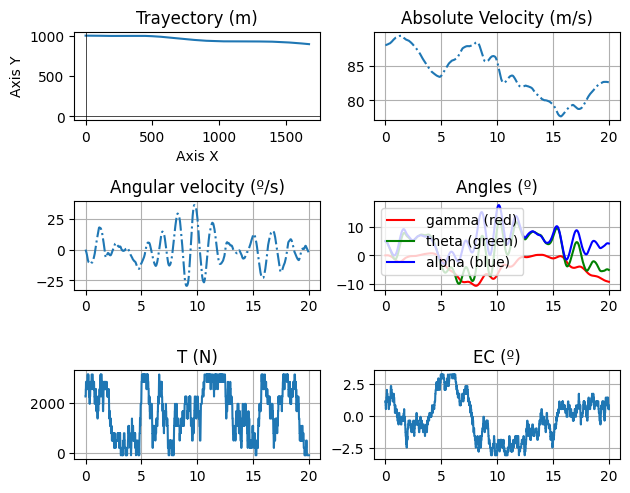

In [ ]:
#MAIN LOOP

deltaT = 0.01
l_t = l_w * 4

# SUPER ESTABLE  state = np.array([0, 1000, 88, 0, 0.087, 0, 2250, 0]) #x,z,v,gamma,theta,v_theta,T
state = np.array([0, 1000, 88, 0, 0.087, 0, 2250, 0.02]) #x,z,v,gamma,theta,v_theta,T
time = 0
matrix_info = np.concatenate((state, [time]))
cur_frame = 0

for i in range(2000):

  action = select_action()
  next_state = environment(state, action)

  time = deltaT * cur_frame
  matrix_info = np.vstack([matrix_info, np.concatenate((state, [time]))])

  state = next_state
  cur_frame += 1

print((state[4]-state[3])*180/pi)
plot_traj(matrix_info)